In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False

In [2]:
np.__version__

'1.19.5'

c:\Users\lunar\anaconda3\envs\fba\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


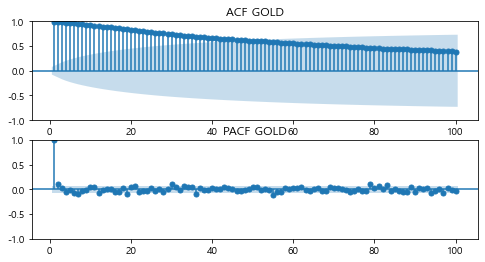

In [3]:
# ACF, PACF TEST
import statsmodels.graphics.tsaplots as sgt

"""
gold = pd.read_csv('USGOLD.csv')
tmp = [list(gold['일자'])[i][0:8] + '01' for i in range(len(gold['일자']))]
gold.index = pd.to_datetime(tmp)
gold = gold.drop(['일자'], axis='columns')
"""



gold = pd.read_csv('USGOLD.csv')
tmp = [list(gold['일자'])[i][0:8] + '01' for i in range(len(gold['일자']))]
gold.index = pd.to_datetime(tmp)
gold = gold.drop(['일자'], axis='columns')
gold.columns = ['GOLD']

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

sgt.plot_acf(gold, lags=100, zero=False, ax=ax1)
ax1.set_title('ACF GOLD')

sgt.plot_pacf(gold, lags=100, zero=False, ax=ax2)
ax2.set_title('PACF GOLD')

plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(array):
    result = adfuller(array)
    print('ADF Statistics: %f'%result[0])
    print('p-value: %f'%result[1])
    print('Critical values')
    for key, value in result[4].items():
        print('\t%s: %.3f'%(key, value))


adf_test(gold['GOLD'])

ADF Statistics: -0.348902
p-value: 0.918287
Critical values
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [5]:
# 중요한 것은 디노말라이제이션 할 때 미래값에 대한 사전인식 편향 없이 가능한가.

def local_normalization(array, size=82):
    data = []
    iteration = len(array) - size + 1 #로컬 평균화에 따른 반복횟수 감소 10개면 (size=3) 8번 반복함
    for i in range(0,iteration):
        tmp = array[i:i+size] # size개만큼 자름
        mean = np.mean(tmp)
        sd = np.std(tmp)
        if i + size <= len(array)-1:
            data.append((array[i + size]-mean)/sd)
    return np.array(data)

In [6]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
def date_range(start, end):
    start = datetime.strptime(start, '%Y-%m-%d')
    end = datetime.strptime(end, '%Y-%m-%d')
    diff = (end.year - start.year) * 12 + end.month - start.month
    dates = [np.datetime64((start + relativedelta(months=i)).strftime("%Y-%m-01")) for i in range(diff+1)]
    return dates

c:\Users\lunar\anaconda3\envs\fba\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


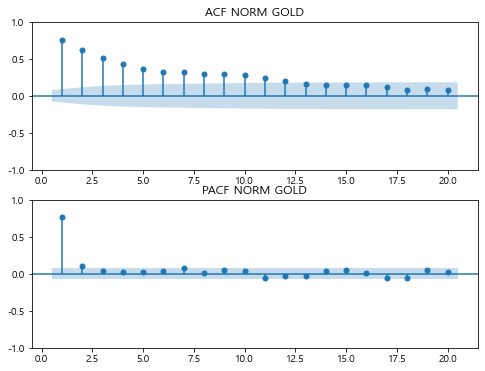

In [7]:
norm_gold = local_normalization(np.array(gold['GOLD']), 10)

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

sgt.plot_acf(norm_gold, lags=20, zero=False, ax=ax1)
ax1.set_title('ACF NORM GOLD')

sgt.plot_pacf(norm_gold, lags=20, zero=False, ax=ax2)
ax2.set_title('PACF NORM GOLD')

norm_gold = pd.DataFrame(norm_gold, index=gold.index[10:], columns=['norm_gold'])
plt.show()

Text(0.5, 1.0, 'SD')

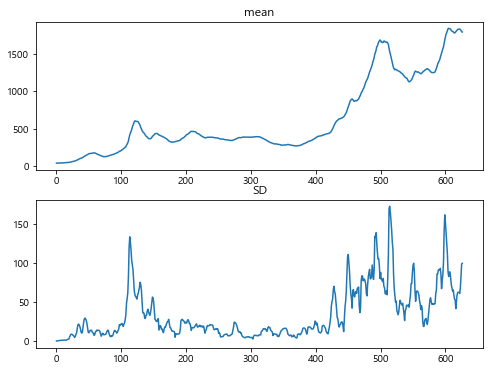

In [8]:
def mean_sd(array, size=82):
    m = []
    s = []
    iteration = len(array) - size + 1
    for i in range(iteration):
        tmp = array[i:i+size]
        mean = np.mean(tmp)
        sd = np.std(tmp)
        m.append(mean)
        s.append(sd)

    return np.array([np.array(m), np.array(s)])


fig = plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.plot(mean_sd(np.array(gold['GOLD']), 10)[0])
plt.title('mean')

plt.subplot(2,1,2)
plt.plot(mean_sd(np.array(gold['GOLD']), 10)[1])
plt.title('SD')

636 626


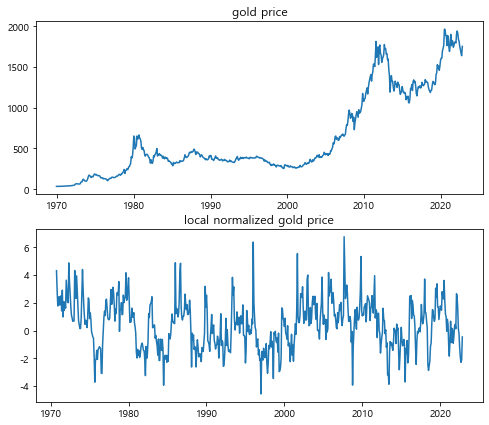

In [9]:
fig = plt.figure(figsize=(8,7))

plt.subplot(2,1,1)
plt.plot(gold['GOLD'])
plt.title('gold price')

plt.subplot(2,1,2)
plt.plot(norm_gold)
plt.title('local normalized gold price')

print(len(gold), len(norm_gold))

In [10]:
colm = ['A','B','C','D','E','F','G','H','I','J','K']
m = pd.read_csv('macro.csv')

dates = date_range(np.array(m['일자'])[0], np.array(m['일자'])[-1])

colm = np.array(m.columns)[1:]
macro = m[colm]


norm_macro = []
for i in range(len(colm)):
    norm_macro.append(local_normalization(macro[colm[i]],size=10))

norm_macro = pd.DataFrame(norm_macro).T
norm_macro.columns = colm
norm_macro.index = dates[10:]
norm_macro.head()

,CPI2,CPI,T10Y,LaborForce,M2,EmployeeNonfarm,T10Y2YM,Unemployment,Crude Oil,CLI,PersonalConsumption
1988-03-01,-0.991390,1.835754,-1.038935,-1.146868,2.376234,0.810324,0.685484,-0.066082,-2.840570,-1.276821,2.336507
1988-04-01,-0.306967,2.222222,-0.107135,-0.838617,2.896460,1.735178,0.865812,-2.022600,-0.710096,-0.837400,1.879261
1988-05-01,0.207261,2.246783,0.727334,-0.311364,1.697773,2.197365,0.148659,-1.277753,-0.764308,-0.402978,2.071892
1988-06-01,-0.038707,2.384615,0.149991,2.933186,1.909763,2.609272,-4.152274,-0.726960,-1.206825,0.060205,2.062052
1988-07-01,0.206596,2.351640,0.466629,3.457402,1.911464,1.126738,-4.005145,-0.620174,-1.536987,0.586284,1.963336


In [11]:
dataset = pd.concat([norm_gold, norm_macro], axis=1).dropna()
old = np.array(dataset['norm_gold'])
gold = np.insert(old[:-1], 0, 0)
dataset['norm_gold'] = gold
dataset = dataset.iloc[1:]

dataset.columns = np.insert(colm, 0, 'label')
dataset.head()

,label,CPI2,CPI,T10Y,LaborForce,M2,EmployeeNonfarm,T10Y2YM,Unemployment,Crude Oil,CLI,PersonalConsumption
1988-04-01,-0.189990,-0.306967,2.222222,-0.107135,-0.838617,2.896460,1.735178,0.865812,-2.022600,-0.710096,-0.837400,1.879261
1988-05-01,-0.679590,0.207261,2.246783,0.727334,-0.311364,1.697773,2.197365,0.148659,-1.277753,-0.764308,-0.402978,2.071892
1988-06-01,-0.320989,-0.038707,2.384615,0.149991,2.933186,1.909763,2.609272,-4.152274,-0.726960,-1.206825,0.060205,2.062052
1988-07-01,-1.363474,0.206596,2.351640,0.466629,3.457402,1.911464,1.126738,-4.005145,-0.620174,-1.536987,0.586284,1.963336
1988-08-01,-1.162882,0.758871,2.214151,1.178674,1.687500,1.481442,1.070762,-3.595441,-0.853595,-1.277802,1.220950,1.934867


In [37]:
import tensorflow as tf

input1 = tf.keras.layers.Input(shape=(22,1,12))
input2 = tf.keras.layers.Input(shape=(18,5,12))
input3 = tf.keras.layers.Input(shape=(13,10,12))


model1 = tf.keras.Sequential([
    input1,
    tf.keras.layers.Conv2D(12,(1,1), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Reshape((22,12)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(22, return_sequences=True), merge_mode='concat'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5, return_sequences=False), merge_mode='concat'),
    tf.keras.layers.Flatten()
])

model2 = tf.keras.Sequential([
    input2,
    tf.keras.layers.Conv2D(12,(1,5), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Reshape((18,12)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(22, return_sequences=True), merge_mode='concat'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5, return_sequences=False), merge_mode='concat'),
    tf.keras.layers.Flatten()
])

model3 = tf.keras.Sequential([
    input3,
    tf.keras.layers.Conv2D(12,(1,10), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Reshape((13,12)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(22, return_sequences=True), merge_mode='concat'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5, return_sequences=False), merge_mode='concat'),
    tf.keras.layers.Flatten()
])

merged = tf.keras.layers.concatenate([model1.output, model2.output, model3.output])
output = tf.keras.layers.Dense(100, activation=tf.nn.relu)(merged)
output = tf.keras.layers.Dense(50)(output)
output = tf.keras.layers.Dense(25)(output)
output = tf.keras.layers.Dense(1)(output)

model = tf.keras.Model(inputs=[input1, input2, input3], outputs=[output])

model.summary()
model.compile('adam', loss='MeanSquaredError', metrics=['accuracy'])

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 22, 1, 12)]  0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 18, 5, 12)]  0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 13, 10, 12)] 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 22, 1, 12)    156         input_19[0][0]                   
_______________________________________________________________________________________

In [52]:
train_set, test_set = dataset.iloc[:350], dataset.iloc[350:]
Y, test_y = norm_gold[190:540][21:], norm_gold[540:][:-1][21:]

test_set.head()

,label,CPI2,CPI,T10Y,LaborForce,M2,EmployeeNonfarm,T10Y2YM,Unemployment,Crude Oil,CLI,PersonalConsumption
2017-06-01,0.189733,-0.385409,1.693368,0.112985,3.625000,1.298736,2.030427,-1.416688,-0.362473,-1.156325,1.282901,1.620332
2017-07-01,-0.098143,-0.553967,1.253088,0.373824,3.172724,1.456533,0.621000,-0.821995,0.097797,-0.571932,1.336400,1.550783
2017-08-01,0.561690,-1.331051,1.565579,-0.353433,0.526894,1.684219,0.777658,-1.513814,-0.168073,0.339278,1.614333,1.647620
2017-09-01,1.877662,-1.640371,2.212032,-1.088977,0.459639,1.822703,1.015632,-1.752201,-1.465436,1.659122,2.100959,2.525448
2017-10-01,0.959542,-1.519220,1.677303,0.238502,-0.598147,1.843058,1.724741,-1.436966,-1.878673,1.946276,2.538268,2.350569


In [53]:
def gen_train_x1(df):
    train_x = []
    df.fillna(1)
    for i in range(len(df.index)-21):
        tmp = []
        for k in range(22):
            tmp.append(np.array(df.iloc[i+k]).tolist())
        train_x.append(tmp)
    
    return np.array(train_x).reshape(-1,22,1,12)



def gen_train_x2(df):
    train_x = []
    df.fillna(1)
    for i in range(len(df.index)-21):
        tmp = []
        for k in range(18):
            tmp.append(np.array(df.iloc[i+k:i+k+5]).tolist())
        train_x.append(tmp)
    
    return np.array(train_x).reshape(-1,18,5,12)

def gen_train_x3(df):
    train_x = []
    df.fillna(1)
    for i in range(len(df.index)-21):
        tmp = []
        for k in range(13):
            tmp.append(np.array(df.iloc[i+k:i+k+10]).tolist())
        train_x.append(tmp)
    
    return np.array(train_x).reshape(-1,13,10,12)

X1 = gen_train_x1(train_set)
X2 = gen_train_x2(train_set)
X3 = gen_train_x3(train_set)

test_x1= gen_train_x1(test_set)
test_x2 = gen_train_x2(test_set)
test_x3 = gen_train_x3(test_set)

In [54]:
X1[0][0]

array([[-0.18999041, -0.30696662,  2.22222222, -0.10713527, -0.83861744,
         2.89646019,  1.73517778,  0.86581197, -2.02259959, -0.71009565,
        -0.83740029,  1.87926133]])

In [55]:
model.fit((X1, X2, X3), Y, batch_size=5, epochs=200, validation_data=((test_x1, test_x2, test_x3), test_y))

Epoch 1/200
66/66 [==============================] - ETA: 0s - loss: 0.7703 - accuracy: 0.0000e+00

ValueError: Data cardinality is ambiguous:
  x sizes: 44, 44, 44
  y sizes: 64
Please provide data which shares the same first dimension.

<AxesSubplot:>

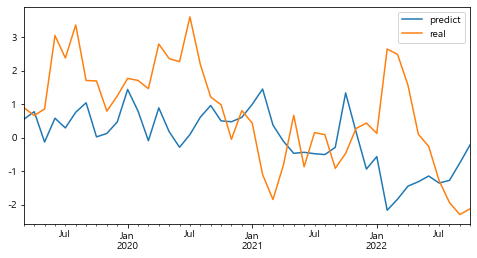

In [39]:
ta = model.predict((test_x1, test_x2, test_x3))
ba = model.predict((X1, X2, X3))
ta = np.squeeze(ta, axis=1)

test_df = pd.DataFrame({
    'predict':ta,
    'real':test_y['norm_gold']
})
test_df.plot(figsize=(8,4))

<AxesSubplot:>

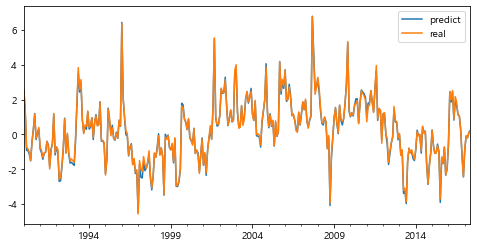

In [40]:
train_df = pd.DataFrame({
    'predict':np.squeeze(ba, axis=1),
    'real':Y['norm_gold']
})

train_df.plot(figsize=(8,4))